In [1]:
%matplotlib notebook
%matplotlib inline

import os

import numpy as np
import pandas as pd
from pandas import DataFrame as df

from matplotlib import pyplot as plt
from IPython.display import Image
from matplotlib.animation import FuncAnimation

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

In [2]:
stats = pd.read_pickle(r'iou3d_old_thresh2.pkl')

In [3]:
BATCH_SIZE = 8
WINDOW_SIZE = BATCH_SIZE * 8
MAX_PLT_COLS = 5
fg_gt_thresh = [0.7, 0.5, 0.5]
fg_pl_thresh = [0.50, 0.45, 0.4]
pre_filtering_thresh = 0.1
cls_names = ['Car', 'Pedestrian', 'Cyclist']

HIST_BIN = np.linspace(pre_filtering_thresh, 1, 20)
palettes = {t: c for t, c in zip(['fp', 'tn', 'tp', 'fn'], sns.color_palette("hls", 4))}
HIST_ARGS = dict(hue='type', fill=True, stat='count', legend=True, bins=HIST_BIN, alpha=0.6, palette=palettes, hue_order=['tp', 'fp', 'fn', 'tn'])

In [4]:
try:
    class_labels = stats['roi_labels']
except KeyError:
    class_labels = stats['class_labels']

In [5]:
stats_dict = {
    'iou_roi_gt': stats['iou_roi_gt'],
    'iou_roi_pl': stats['iou_roi_pl'],
    'iteration' : stats['iteration'],
    'class_labels': class_labels,
    'pred_scores': stats['pred_scores']
}
stats_df = pd.DataFrame(stats_dict)

stats_df['class_labels'] = stats_df['class_labels'].astype('int32')
stats_df['iteration'] = stats_df['iteration'].astype('int32')
stats_df = stats_df[pre_filtering_thresh <= stats_df['iou_roi_pl']]

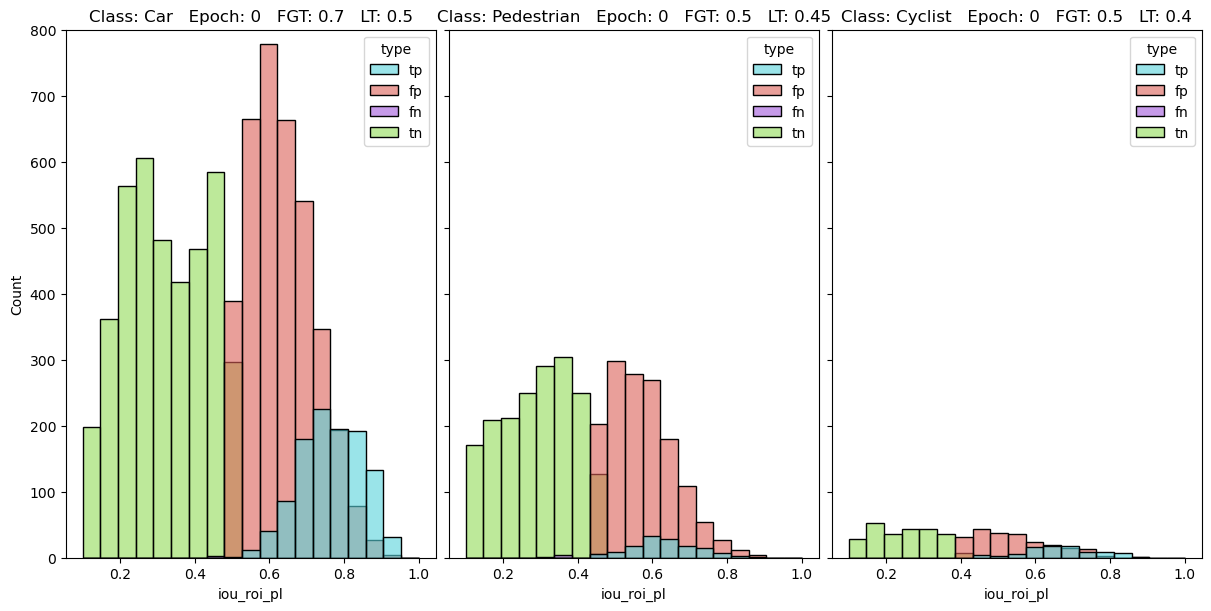

In [6]:
fig, axes = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(12, 6), layout="compressed")

num_windows = stats_df.iteration.max() // WINDOW_SIZE + 1
stats_df['window'] = (stats_df['iteration']) // WINDOW_SIZE
stats_df['type'] = 'none'

def update(w):
    window_df = stats_df.groupby("window").get_group(w)
    for cind, class_name in enumerate(cls_names):
        cls_df = window_df[window_df['class_labels'] == cind+1]

        gt_score = cls_df['iou_roi_gt']
        iou_score = cls_df['iou_roi_pl']

        classwise_fg_thr = fg_gt_thresh[cind] # scalar
        classwise_local_thr = fg_pl_thresh[cind] # scalar

        tp_mask = (gt_score >= classwise_fg_thr) & (iou_score >= classwise_local_thr)
        fp_mask = (gt_score < classwise_fg_thr) & (iou_score >= classwise_local_thr)
        fn_mask = (gt_score >= classwise_fg_thr) & (iou_score < classwise_local_thr)
        tn_mask = (gt_score < classwise_fg_thr) & (iou_score < classwise_local_thr)

        cls_df['type'][tp_mask] = 'tp'
        cls_df['type'][fp_mask] = 'fp'
        cls_df['type'][fn_mask] = 'fn'
        cls_df['type'][tn_mask] = 'tn'
        
        axes[cind].cla()
        axes[cind].set_title(f'Class: {class_name}   Epoch: {w}   FGT: {classwise_fg_thr}   LT: {classwise_local_thr}')
        sns.histplot(ax=axes[cind] , data=cls_df, x="iou_roi_pl", **HIST_ARGS)
        
        axes[cind].set_ylim(0, 800)

# Save the animation as a GIF
anim = FuncAnimation(fig, update, num_windows, interval=100)
anim.save(f'animation_baseline_ws{WINDOW_SIZE}.gif', writer='pillow')

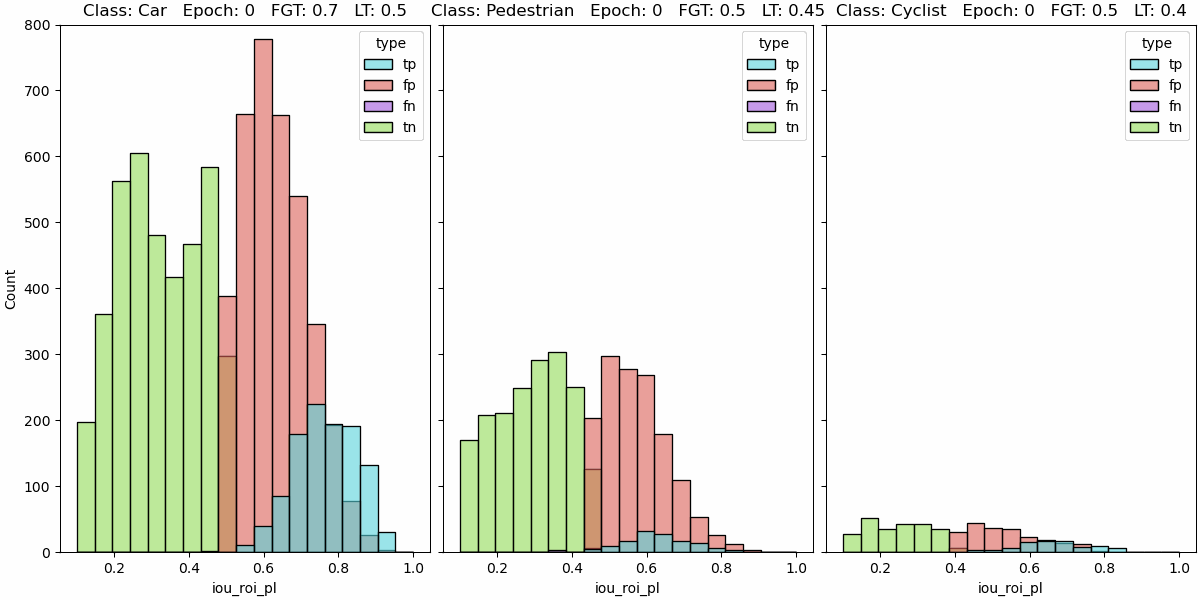

In [7]:
Image(filename=f'animation_baseline_ws{WINDOW_SIZE}.gif')

In [8]:
"""
Accumulate the stats with the rolling window (with the window_size based on the iteration) and show the histograms
of `roi_iou_pl` or `pred_scores` throughout the training
"""

def plot_corres_gt(stats_df: pd.DataFrame, window_size=WINDOW_SIZE):

    num_windows = stats_df.iteration.max() // window_size + 1
    stats_df['window'] =  stats_df['iteration'] // window_size

    num_plt_rows = num_windows // MAX_PLT_COLS + 1
    f, axes = plt.subplots(num_plt_rows, MAX_PLT_COLS, sharex='col', sharey='row', figsize=(12,20), layout="compressed")
    for w, ax in tqdm(zip(range(num_windows), axes.flat), total=num_windows):
        window_df = stats_df.groupby("window").get_group(w)

        cls_df = window_df[window_df['class_labels'] == cls_ind]
        sns.histplot(ax=ax, data=cls_df, x="iou_roi_pl", **hist_args)
        ax.set_title(f"Window {w}")
        
        if (w + 1) % MAX_PLT_COLS == 1:  # First col
            ax.xaxis.set_tick_params(bottom=False)

        elif (w + 1) // MAX_PLT_COLS == num_plt_rows - 1:  # Last row
            ax.yaxis.set_tick_params(left=False)
        else:
            ax.xaxis.set_tick_params(bottom=False)
            ax.yaxis.set_tick_params(left=False)
        
    
    f.subplots_adjust(wspace=0.1, hspace=0.2)
    f.suptitle(f"Histograms of {cls_names[cls_ind-1]} class.")
#     f.tight_layout()
    # f.savefig(fname=f"dist_all.pdf", transparent=True, bbox_inches='tight')
    plt.show()

In [9]:
# plot_corres_gt(stats_df)